In [1]:
import torch
import torchvision.transforms as transforms
from torchvision.utils import save_image
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torchvision import datasets
import matplotlib.pyplot as plt
import numpy as np
from torchvision.utils import make_grid
from torch.utils.data import random_split


In [21]:
training_data = datasets.CIFAR10(
    root="data",
    train=True,
    download=True,
    transform= transforms.Compose([transforms.Resize((28,28)),transforms.Grayscale(num_output_channels=1),transforms.ToTensor()]))


test_data = datasets.CIFAR10(
    root="data",
    train=False,
    download=True,
    transform=transforms.Compose([transforms.Resize((28,28)),transforms.Grayscale(num_output_channels=1),transforms.ToTensor()]))

Files already downloaded and verified
Files already downloaded and verified


In [3]:
len(training_data)

50000

In [4]:
names=["airplane",
"automobile",
"bird",
"cat",
"deer",
"dog",
"frog",
"horse",
"ship",
"truck"]

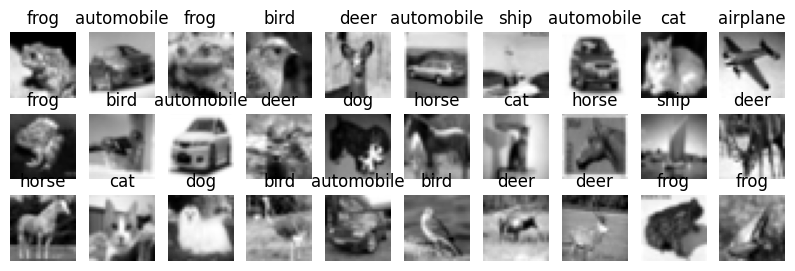

In [5]:
fig, axs = plt.subplots(3, 10, figsize=((10, 3)))
for ax, train_file in zip(axs.ravel(), np.random.choice(len(training_data), axs.size)):
    image = training_data[train_file][0]
    ax.imshow(image.squeeze(),cmap='gray')
    ax.set_axis_off()
    ax.set_title(names[training_data[train_file][1]])
plt.show()

In [6]:
train_loader = DataLoader(training_data, batch_size=50000, shuffle=True)
img, lbl=next(iter(train_loader))


In [ ]:

!pip install deeplay
import deeplay as dl
from torch.nn import BCELoss, MSELoss

In [8]:

vae = dl.VariationalAutoEncoder(
    channels=[64, 128],
    latent_dim=2,
    reconstruction_loss=BCELoss(reduction="sum"),
    beta=1,
).create()
print(vae)
vae_trainer = dl.Trainer(max_epochs=100, accelerator="auto")

dataset=TensorDataset(img,img)
train_loader2 = DataLoader(dataset, batch_size=70, shuffle=True)


VariationalAutoEncoder(
  (encoder): ConvolutionalEncoder2d(
    (blocks): LayerList(
      (0): PoolLayerActivationNormalization(
        (pool): Identity()
        (layer): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (activation): ReLU()
        (normalization): Identity()
      )
      (1): PoolLayerActivationNormalization(
        (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (layer): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (activation): ReLU()
        (normalization): Identity()
      )
      (2): PoolLayerActivationNormalization(
        (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (layer): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (activation): ReLU()
        (normalization): Identity()
      )
    )
    (postprocess): Flatten(start_dim=1, end_dim=-1)
  )
  (fc_mu): Linear(in_features=6272, ou

In [9]:
def show_batch(dl):
  for images,labels in dl:
    fig, ax=plt.subplots(figsize=(12,6))
    ax.set_xticks([]);ax.set_yticks([])
    ax.imshow(make_grid(images, nrow=10).permute(1,2,0))
    break



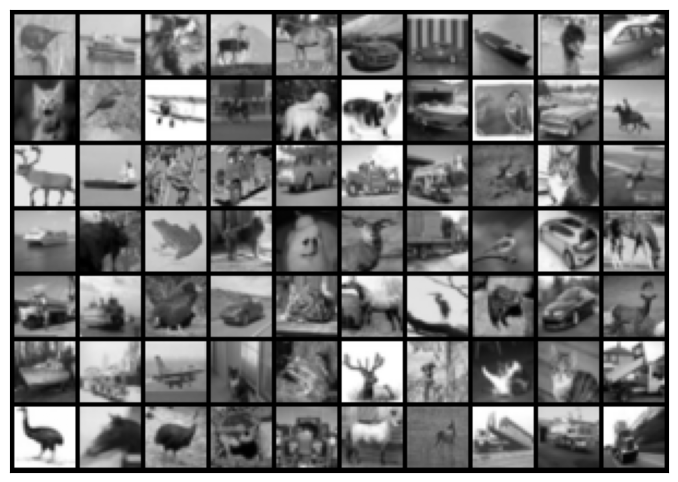

In [10]:
show_batch(train_loader2)

In [11]:
vae_trainer.fit(vae, train_loader2)

/usr/local/lib/python3.10/dist-packages/lightning/pytorch/trainer/configuration_validator.py:74: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
INFO: 
  | Name                | Type                   | Params
---------------------------------------------------------------
0 | encoder             | ConvolutionalEncoder2d | 222 K 
1 | fc_mu               | Linear                 | 12.5 K
2 | fc_var              | Linear                 | 12.5 K
3 | fc_dec              | Linear                 | 18.8 K
4 | decoder             | ConvolutionalDecoder2d | 304 K 
5 | reconstruction_loss | BCELoss                | 0     
6 | train_metrics       | MetricCollection       | 0     
7 | val_metrics         | MetricCollection       | 0     
8 | test_metrics        | MetricCollection       | 0     
9 | optimizer           | Adam                   | 0     
---------------------------------------------------------------
570 K     Trainable params
0         Non-trainabl

Training: |          | 0/? [00:00<?, ?it/s]

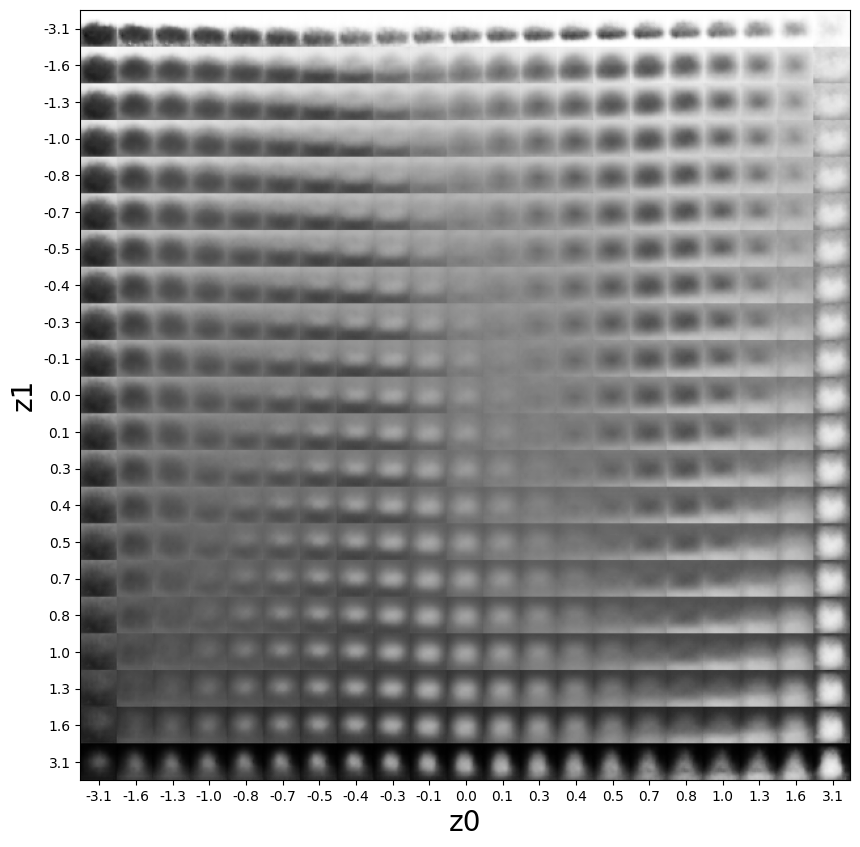

In [12]:

from torch.distributions.normal import Normal

img_num, img_size = 21, 28

z0_grid = Normal(0, 1).icdf(torch.linspace(0.001, 0.999, img_num))
z1_grid = Normal(0, 1).icdf(torch.linspace(0.001, 0.999, img_num))

image = np.zeros((img_num * img_size, img_num * img_size))

for i0, z0 in enumerate(z0_grid):
    for i1, z1 in enumerate(z1_grid):
        z = torch.stack((z0, z1)).unsqueeze(0)
        generated_image = vae.decode(z).clone().detach()
        image[
            i1 * img_size : (i1 + 1) * img_size,
            i0 * img_size : (i0 + 1) * img_size,
        ] = generated_image.numpy().squeeze()

plt.figure(figsize=(10, 10))
plt.imshow(image, cmap="gray")
plt.xticks(
    np.arange(0.5 * img_size, (0.5 + img_num) * img_size, img_size),
    np.round(z0_grid.numpy(), 1),
)
plt.yticks(
    np.arange(0.5 * img_size, (0.5 + img_num) * img_size, img_size),
    np.round(z1_grid.numpy(), 1),
)
plt.xlabel("z0", fontsize=20)
plt.ylabel("z1", fontsize=20)
plt.show()

In [22]:
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

In [14]:
label_names ={0: 'airplane', 1: 'automobile', 2: 'bird', 3: 'cat', 4: 'deer', 5: 'dog', 6: 'frog', 7: 'horse', 8: 'ship', 9: 'truck'}


In [23]:
mu_list, test_labels = [], []  ### Carlo: changed z back to mu
for image, label in test_dataloader:
    mu, _ = vae.encode(image.view(-1,1,28,28))
    mu_list.append(mu)
    test_labels.append(label)
mu_tensor = torch.cat(mu_list, dim=0).detach().numpy()
test_labels = torch.cat(test_labels, dim=0).numpy()

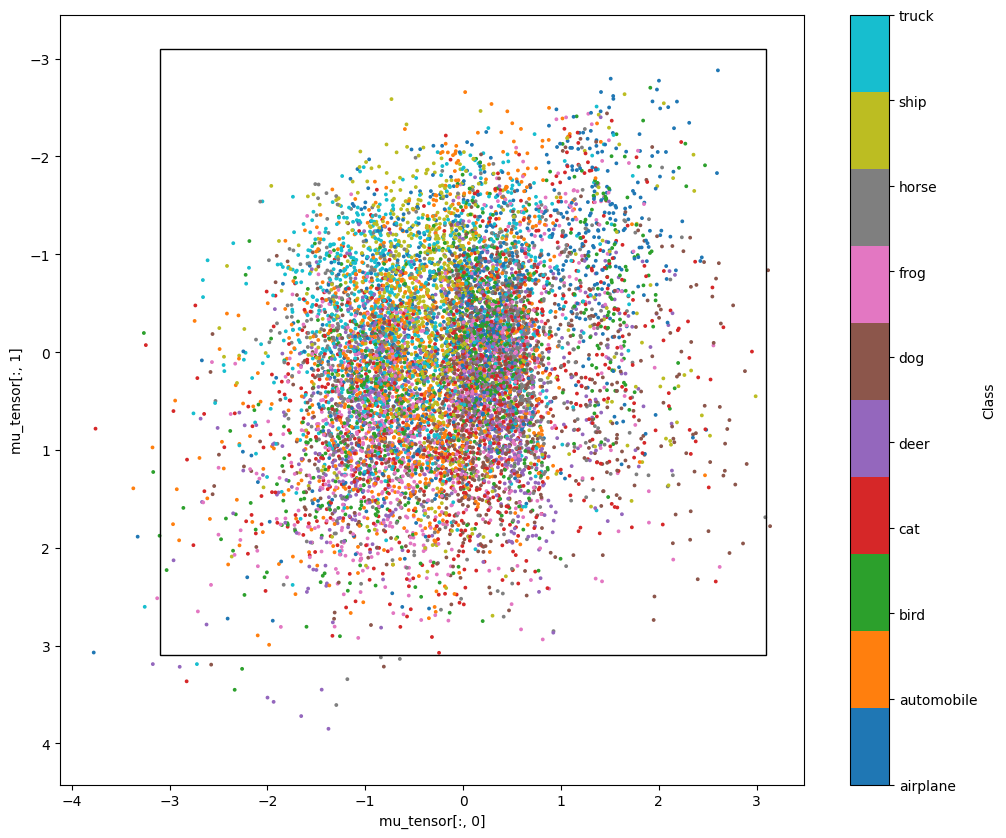

In [24]:
from matplotlib.patches import Rectangle

plt.figure(figsize=(12, 10))
scatter =plt.scatter(mu_tensor[:, 0], mu_tensor[:, 1], s=3, c=test_labels, cmap="tab10")
plt.xlabel("mu_tensor[:, 0]")
plt.ylabel("mu_tensor[:, 1]")

cbar = plt.colorbar(scatter, ticks=range(len(label_names)), label='Class')
cbar.set_ticklabels([label_names[i] for i in range(len(label_names))])

plt.gca().invert_yaxis()  ### Carlo: this is important to keep the same order as the plot above
plt.axis("equal")
plt.gca().add_patch(Rectangle((-3.1, -3.1), 6.2, 6.2, fc="none", ec="k", lw=1))
plt.show()